# Chapter 2 자연어와 단어의 분산 표현

## 2.3 통계 기반 기법

### 2.3.1 파이썬으로 말뭉치 전처리하기

작은 말뭉치를 전처리

In [2]:
# 단어 단위로 분할
text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [3]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

정규표현식을 사용하면 더 간단히 처리가능

In [4]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [5]:
print(id_to_word)
print(word_to_id)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [6]:
id_to_word[1], word_to_id['hello']

('say', 5)

In [7]:
# 단어 목록을 단어ID 목록으로 변경
import numpy as np

corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [1]:
# 최종 함수
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [8]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

### 2.3.4 동시발생 행렬

In [9]:
# 전처리부터
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [10]:
# 동시발생 행렬 구현
C = np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0],
], dtype=np.int32)

In [12]:
print(C[word_to_id['goodbye']])

[0 1 0 1 0 0 0]


In [13]:
# 동시발생 행렬 구현 함수
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

In [15]:
create_co_matrix(corpus, 7)

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

### 2.3.5 벡터 간 유사도

In [17]:
# 코사인 유사도
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

In [18]:
# 유사도 구하기
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]  # "you"의 단어 벡터
c1 = C[word_to_id['i']]    # "i"의 단어 벡터
print(cos_similarity(c0, c1))

0.7071067758832467


### 2.3.6 유사 단어의 랭킹 표시

In [19]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 검색어 꺼내기
    if query not in word_to_id:
        print(f"{query}(을)를 찾을 수 없습니다.")
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도 기준으로 내림차순 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f" {id_to_word[i]}: {similarity[i]}")

        count += 1
        if count >= top:
            return

In [20]:
# 적용
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


## 2.4 통계 기반 기법 개선

### 2.4.1 상호정보량

PPMI(x, y) = max(0, PMI(x, y))

In [23]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print(f'{100*cnt/total:.1f}%% 완료')
    return M

In [24]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 2.4.3 SVD에 의한 차원 감소

In [25]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

In [27]:
print(C[0])

print(W[0])

print(U[0])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


In [28]:
# 차원축소
U[0, :2]

array([ 3.409e-01, -1.110e-16], dtype=float32)

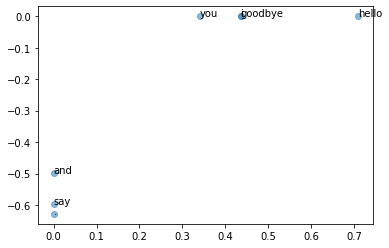

In [29]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

### 2.4.4 PTB 데이터셋

In [31]:
import sys, os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
os.chdir('/content/drive/MyDrive/DL_from_bottom_2')

In [37]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

len(corpus)

Done


929589

### 2.4.5 PTB 데이터셋 평가

In [38]:
from sklearn.utils.extmath import randomized_svd

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C)

print('SVD 계산...')
try:
    # truncated SVD
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
    
except ImportError:
    # SVD
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...
SVD 계산...

[query] you
 i: 0.6409546136856079
 we: 0.6183379888534546
 'll: 0.546333372592926
 'd: 0.5359408259391785
 anybody: 0.5193808078765869

[query] year
 last: 0.6378474831581116
 month: 0.6296255588531494
 quarter: 0.6067923307418823
 earlier: 0.5838028788566589
 next: 0.5780812501907349

[query] car
 luxury: 0.5802417397499084
 auto: 0.5651928782463074
 domestic: 0.5477470755577087
 corsica: 0.5145746469497681
 cars: 0.49521568417549133

[query] toyota
 nissan: 0.713415801525116
 motor: 0.7088461518287659
 motors: 0.6392045617103577
 honda: 0.617780327796936
 lexus: 0.5906472206115723
